In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.conv_learner import *
from fastai.dataset import *

from pathlib import Path
import json


In [3]:
torch.cuda.is_available()

True

In [4]:
torch.backends.cudnn.enabled

True

## Dataset

In [5]:
PATH = Path('/home/ubuntu/fastai/data/roads/mass_roads_png_128')
os.listdir(PATH)

['train', 'tmp', 'models', 'valid', 'test']

In [6]:
sz = 128
bs = 64

aug_tfms = []

In [7]:
TRAIN_DATA_x = '{}/train/sat'.format(PATH)
TRAIN_DATA_y = '{}/train/map'.format(PATH)
trn_x = glob(os.path.join(TRAIN_DATA_x, "*.png"))
trn_y = glob(os.path.join(TRAIN_DATA_y, "*.png"))
#train_ids_150 = [s[len(TRAIN_DATA)+1:-5] for s in train_files_150]
#train_ids_150[:5]

In [8]:
TRAIN_DATA_x

'/home/ubuntu/fastai/data/roads/mass_roads_png_128/train/sat'

In [9]:
!ls {TRAIN_DATA_x} | wc -l

17728


In [10]:
VALID_DATA_x = '{}/valid/sat'.format(PATH)
VALID_DATA_y = '{}/valid/map'.format(PATH)
val_x = glob(os.path.join(VALID_DATA_x, "*.png"))
val_y = glob(os.path.join(VALID_DATA_y, "*.png"))


In [11]:
trn_x[:10]

['/home/ubuntu/fastai/data/roads/mass_roads_png_128/train/sat/10228795_15_12.png',
 '/home/ubuntu/fastai/data/roads/mass_roads_png_128/train/sat/15778825_15_7.png',
 '/home/ubuntu/fastai/data/roads/mass_roads_png_128/train/sat/22229425_15_9.png',
 '/home/ubuntu/fastai/data/roads/mass_roads_png_128/train/sat/16228945_15_13.png',
 '/home/ubuntu/fastai/data/roads/mass_roads_png_128/train/sat/11128765_15_13.png',
 '/home/ubuntu/fastai/data/roads/mass_roads_png_128/train/sat/19528630_15_3.png',
 '/home/ubuntu/fastai/data/roads/mass_roads_png_128/train/sat/23578780_15_7.png',
 '/home/ubuntu/fastai/data/roads/mass_roads_png_128/train/sat/23579050_15_2.png',
 '/home/ubuntu/fastai/data/roads/mass_roads_png_128/train/sat/19978630_15_4.png',
 '/home/ubuntu/fastai/data/roads/mass_roads_png_128/train/sat/23728825_15_2.png']

In [12]:
img = Image.open(val_y[0])
np.asarray(img).shape

(128, 128)

In [13]:
img = Image.open(trn_y[0])
np.asarray(img).shape

(128, 128)

In [14]:
print('Len train sat: {} len train mask: {}'.format(len(trn_x), len(trn_y)))
print('Len valid sat: {} Len Valid mask: {}'.format(len(val_x), len(val_y)))

Len train sat: 17728 len train mask: 17728
Len valid sat: 1008 Len Valid mask: 1008


In [15]:
class MatchedFilesDataset(FilesDataset):
    def __init__(self, fnames, y, transform, path):
        self.y=y
        assert(len(fnames)==len(y))
        super().__init__(fnames, transform, path)
    def get_y(self, i): return open_image(os.path.join(self.path, self.y[i]))
    def get_c(self): return 0

In [16]:
arch=resnet34
tfms = tfms_from_model(resnet34, sz, crop_type=CropType.NO, tfm_y=TfmType.CLASS, aug_tfms=[])
datasets = ImageData.get_ds(MatchedFilesDataset, (trn_x,trn_y), (val_x,val_y), tfms, path=PATH)
md = ImageData(PATH, datasets, bs, num_workers=8, classes=None)

## Model

In [17]:
class StdUpsample(nn.Module):
    def __init__(self, nin, nout):
        super().__init__()
        self.conv = nn.ConvTranspose2d(nin, nout, 2, stride=2)
        self.bn = nn.BatchNorm2d(nout)
        
    def forward(self, x): return self.bn(F.relu(self.conv(x)))

In [18]:
flatten_channel = Lambda(lambda x: x[:,0])

In [19]:
simple_up = nn.Sequential(
    nn.ReLU(),
    StdUpsample(512,256),
    StdUpsample(256,256),
    StdUpsample(256,256),
    StdUpsample(256,256),
    nn.ConvTranspose2d(256, 1, 2, stride=2),
    flatten_channel
)

In [20]:
models = ConvnetBuilder(resnet34, 0, 0, 0, custom_head=simple_up)
learn = ConvLearner(md, models)
learn.opt_fn=optim.Adam
learn.crit=nn.BCEWithLogitsLoss()
learn.metrics=[accuracy_thresh(0.5)]

 79%|███████▊  | 218/277 [01:10<00:19,  3.09it/s, loss=2.75] 

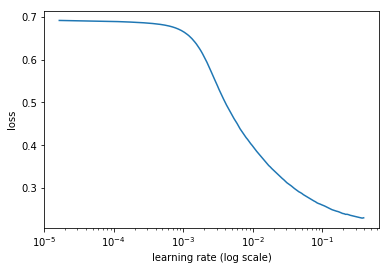

In [21]:
learn.lr_find()
learn.sched.plot()

In [22]:
lr=1e-1

In [24]:
learn.fit(lr,1,cycle_len=5,use_clr=(20,5))

  9%|▉         | 26/277 [00:08<01:24,  2.97it/s, loss=0.371]
epoch      trn_loss   val_loss   <lambda>                    
    0      0.178175   0.186164   0.948119  
    1      0.178702   0.184872   0.948119                    
    2      0.175048   0.183909   0.948119                    
    3      0.172801   0.184247   0.948119                    
    4      0.171093   0.182779   0.948119                    



[0.182779180388602, 0.9481194501831418]

In [25]:
learn.save('128')

In [26]:
learn.load('128')

In [27]:
py,ay = learn.predict_with_targs()

In [28]:
ay.shape

(1008, 128, 128)

In [29]:
def show_img(im, figsize=None, ax=None, alpha=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im, alpha=alpha)
    ax.set_axis_off()
    return ax

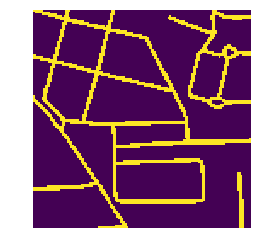

In [33]:
show_img(ay[3])

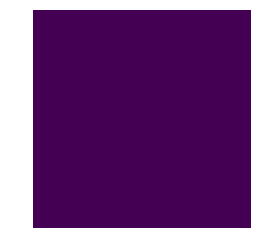

In [34]:
show_img(py[3]>0);

In [35]:
learn.unfreeze()

In [36]:
learn.bn_freeze(True)

In [37]:
lrs = np.array([lr/100,lr/10,lr])/4

In [38]:
learn.fit(lrs,1,cycle_len=8,use_clr=(20,8))

epoch      trn_loss   val_loss   <lambda>                    
    0      0.148291   0.14165    0.948417  
    1      0.128021   0.122632   0.952111                    
    2      0.11741    0.117096   0.954359                    
    3      0.111121   0.109789   0.956639                    
    4      0.107457   0.10801    0.958578                    
    5      0.099892   0.107552   0.958803                     
    6      0.09263    0.110182   0.95961                      
    7      0.085795   0.115383   0.959634                     



[0.1153828397629753, 0.9596343276992677]

In [39]:
learn.save('128')

In [40]:
x,y = next(iter(md.val_dl))
py = to_np(learn.model(V(x)))

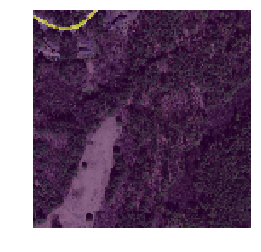

In [41]:
denorm = md.trn_ds.denorm
ax = show_img(denorm(x)[0])
show_img(py[0]>0, ax=ax, alpha=0.5);

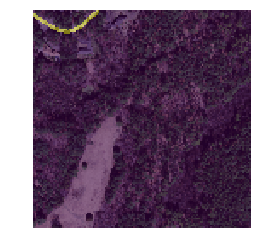

In [42]:
ax = show_img(denorm(x)[0])
show_img(y[0], ax=ax, alpha=0.5);

## 512x512

In [43]:
PATH = Path('/home/ubuntu/fastai/data/roads/mass_roads_png_512')
os.listdir(PATH)
sz = 512
bs = 16

In [44]:
TRAIN_DATA_x = '{}/train/sat'.format(PATH)
TRAIN_DATA_y = '{}/train/map'.format(PATH)
trn_x = glob(os.path.join(TRAIN_DATA_x, "*.png"))
trn_y = glob(os.path.join(TRAIN_DATA_y, "*.png"))

VALID_DATA_x = '{}/valid/sat'.format(PATH)
VALID_DATA_y = '{}/valid/map'.format(PATH)
val_x = glob(os.path.join(VALID_DATA_x, "*.png"))
val_y = glob(os.path.join(VALID_DATA_y, "*.png"))


In [45]:
arch=resnet34
tfms = tfms_from_model(resnet34, sz, crop_type=CropType.NO, tfm_y=TfmType.CLASS, aug_tfms=[])
datasets = ImageData.get_ds(MatchedFilesDataset, (trn_x,trn_y), (val_x,val_y), tfms, path=PATH)
md = ImageData(PATH, datasets, bs, num_workers=8, classes=None)

In [46]:
denorm = md.trn_ds.denorm
x,y = next(iter(md.aug_dl))
x = denorm(x)

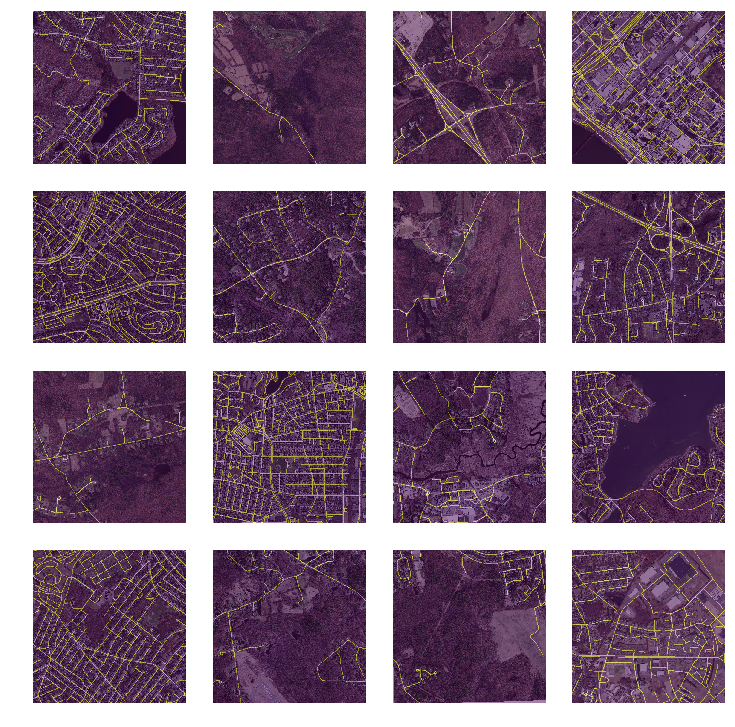

In [47]:
fig, axes = plt.subplots(4, 4, figsize=(10, 10))
for i,ax in enumerate(axes.flat):
    ax=show_img(x[i], ax=ax)
    show_img(y[i], ax=ax, alpha=0.5)
plt.tight_layout(pad=0.1)

In [48]:
simple_up = nn.Sequential(
    nn.ReLU(),
    StdUpsample(512,256),
    StdUpsample(256,256),
    StdUpsample(256,256),
    StdUpsample(256,256),
    nn.ConvTranspose2d(256, 1, 2, stride=2),
    flatten_channel
)

In [49]:
# Don't actuallu understand this bit of code. :(

models = ConvnetBuilder(resnet34, 0, 0, 0, custom_head=simple_up)
learn = ConvLearner(md, models)
learn.opt_fn=optim.Adam
learn.crit=nn.BCEWithLogitsLoss()
learn.metrics=[accuracy_thresh(0.5)]

In [51]:
learn.load('128')

 81%|████████▏ | 57/70 [01:03<00:14,  1.12s/it, loss=0.789]

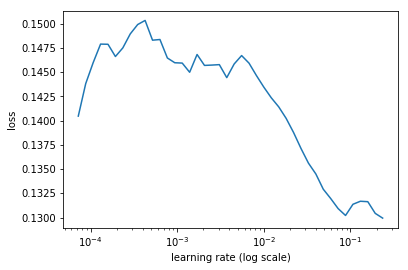

In [52]:
learn.lr_find()
learn.sched.plot()

In [53]:
# Set the learning rate from above plot
lr=6e-1

In [54]:
learn.save('512')

In [55]:
learn.load('512')

In [56]:
learn.unfreeze()
learn.bn_freeze(True)

In [57]:
lrs = np.array([lr/100,lr/10,lr])/4

In [59]:
learn.fit(lrs,1,cycle_len=8,use_clr=(20,8))

  3%|▎         | 2/70 [00:05<03:03,  2.69s/it, loss=0.0904]
epoch      trn_loss   val_loss   <lambda>                     
    0      8446.425611 35.386879  0.924573  
    1      1.7988344306777215e+19 0.299604   0.948119         
    2      4.174864253812558e+18 0.313012   0.948119          
    3      1.0039250670163203e+18 0.205989   0.948119         
    4      2.434308689770429e+17 0.204294   0.948119          
    5      5.9145483568971496e+16 0.209438   0.948119         
    6      1.4377354909443312e+16 0.204096   0.948119         
    7      3495326805780369.0 0.204223   0.948119             



[0.20422285298506418, 0.9481194577519856]

In [60]:
learn.save('512')

In [61]:
x,y = next(iter(md.val_dl))
py = to_np(learn.model(V(x)))

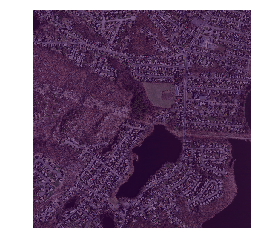

In [66]:
ax = show_img(denorm(x)[0])
show_img(py[0]>0, ax=ax, alpha=0.5);

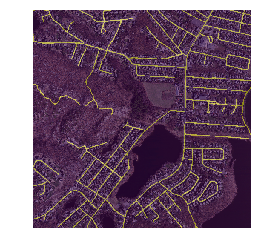

In [65]:
ax = show_img(denorm(x)[0])
show_img(y[0], ax=ax, alpha=0.5);

## 1024x1024